<a href="https://colab.research.google.com/github/ubsuny/LLPS-ProteinRNA_Condensates-CP2P2024/blob/main/tensorflow_msd_calculation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install multipletau

In [ ]:
!pip install lmfit


In [ ]:
pip install tensorflow


In [ ]:
import matplotlib.pyplot as plt
import math
from multipletau import autocorrelate
import array
import lmfit
import scipy as sp
import numpy as np
from os import listdir
import sys, os.path

def ReadTable(filename, beadindx=-1, X=0, Y=1, indx=2, skip=1):
    if os.path.isfile(filename):
        fp = open(filename, 'rt')
    else:
        print("file not found: %s" % filename)
        return None
    a = fp.readlines()
    fp.close()
    a = a[skip:]
    Ni = len(a)
    t = (a[0].strip()).split(',')
    Nj = len(t) - 1
    res = []
    for i in range(Ni):
        t = a[i].strip().split(',')
        l = []
        for j in range(Nj):
            if t[j + 1] == '':
                continue
            l.append(float(t[j + 1]))
        res.append(l)
    print("Found: %d lines" % len(res))
    res = nu.asarray(res)
    Nb = nu.unique(res[:, beadindx - 1])
    print("Max: %d beads" % len(Nb))
    poslist = []
    for i in Nb:
        bindx = (res[:, beadindx - 1] == i)
        poslist.append({"X": res[bindx, X - 1], "Y": res[bindx, Y - 1],
                        "indx": res[bindx, indx - 1]})
    print("Found: %d beads" % len(poslist))
    return poslist

import xml.etree.ElementTree as et
def loadxmlTrajs(xmlfile):
    try:
        tree = et.parse(xmlfile);
    except OSError:
        print('Failed to read XML file {}.'.format(xmlfile))
    root = tree.getroot()
    nTracks = int(root.attrib['nTracks'])
    tracks = {}
    for i in range(nTracks):
        trackIdx = str(i)
        tracks[trackIdx] = {}
        nSpots = int(root[i].attrib['nSpots'])
        tracks[trackIdx]['nSpots'] = nSpots
        trackData = np.array([]).reshape(0, 4)
        for j in range(nSpots):
            t = float(root[i][j].attrib['t'])
            x = float(root[i][j].attrib['x'])
            y = float(root[i][j].attrib['y'])
            z = float(root[i][j].attrib['z'])
            spotData = np.array([t, x, y, z])
            trackData = np.vstack((trackData, spotData))
        tracks[trackIdx]['trackData'] = trackData
    return tracks
def get_outlier_bounds(first_values, last_values):
    sorted_f = np.sort(np.log(first_values))
    q1, q3 = np.percentile(sorted_f, [25, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    sorted_l = np.sort(np.log(last_values))
    q1, q3 = np.percentile(sorted_l, [25, 75])
    iqr = q3 - q1
    lower_bound_l = q1 - (1 * iqr)
    upper_bound_l = q3 + (1.5 * iqr)
    return lower_bound, upper_bound, lower_bound_l, upper_bound_l


In [ ]:
import os
format_file = '.xml'
directory_path = "/content"
files = os.listdir(directory_path)
scans = []
for file in files:
    if format_file in file:
        scans.append(file)
index = np.arange(len(scans))
insca = zip(list(index), scans)
insca_list = list(insca)
print(insca_list)


[(0, 'video5_1_MMStack_Pos0_Tracks.xml')]


In [ ]:
index_to_analyze = 0
fname = scans[index_to_analyze]
fname = fname[0:len(fname)-4]
pos = loadxmlTrajs(fname+'.xml')
total_duration = 100
total_frames = 1000
frametime = total_duration / total_frames
pixel_conversion = 1
R = 0.5
T = 20

In [ ]:
sizes = np.zeros((len(pos),))
for i in range(len(pos)):
    sizes[i] = pos[str(i)]['nSpots']
lastframe = int(max(sizes))
minframe = int(min(sizes))

In [ ]:
lastframe, len(pos)

(1000, 23)

In [ ]:
dx_all = np.zeros(int(lastframe - 1),)
dy_all = np.zeros(int(lastframe - 1),)
count_all = np.zeros(int(lastframe - 1),)
counts = []
for j in range(int(len(pos))):
    Vavg = 0
    Xavg = 0
    count = 0
    dx = np.diff(pos[str(j)]['trackData'][:, 1])
    dy = np.diff(pos[str(j)]['trackData'][:, 2])
    time = pos[str(j)]['trackData'][:, 0]
    start = int(time[0])
    end = start + len(dx)
    dx_all[start:end] = dx_all[start:end] + dx
    dy_all[start:end] = dy_all[start:end] + dy
    count_all[start:end] = count_all[start:end] + 1
    dx_avg = dx_all / count_all
    dy_avg = dy_all / count_all
Xcom0 = 0
Ycom0 = 0
for key in pos:
    Xcom0 += pos[key]['trackData'][0, 1]
    Ycom0 += pos[key]['trackData'][0, 2]
X0 = Xcom0 / len(pos)
Y0 = Ycom0 / len(pos)
Xcom = [X0 + sum(dx_avg[:i]) for i in range(int(lastframe))]
Ycom = [Y0 + sum(dy_avg[:i]) for i in range(int(lastframe))]


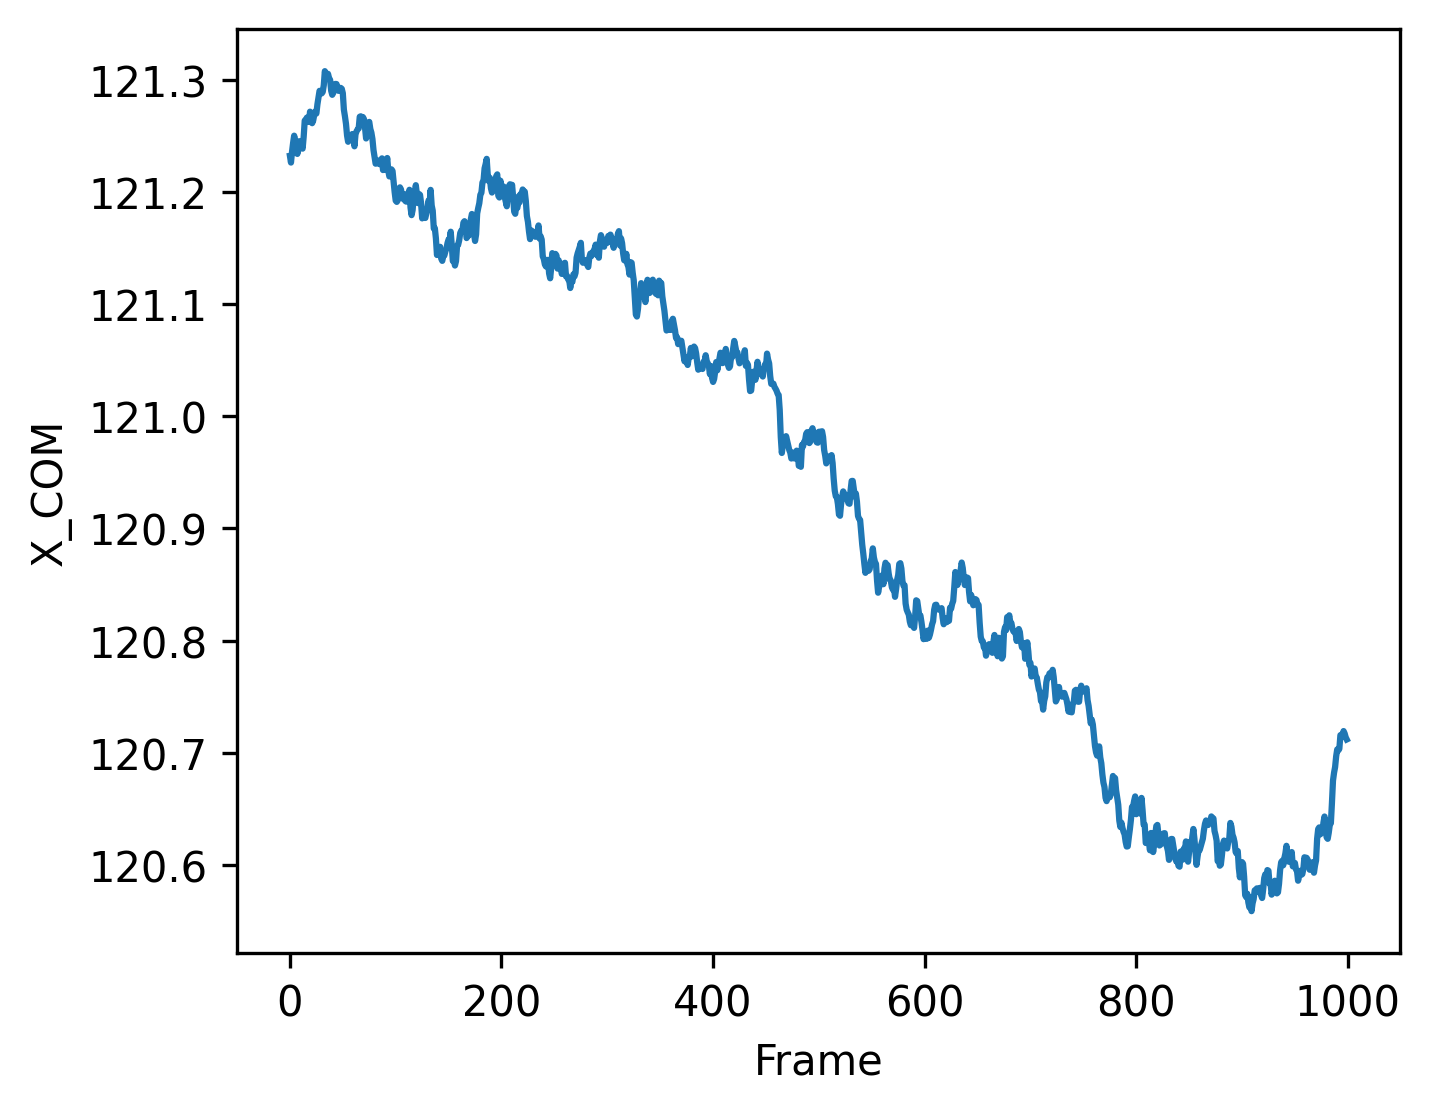

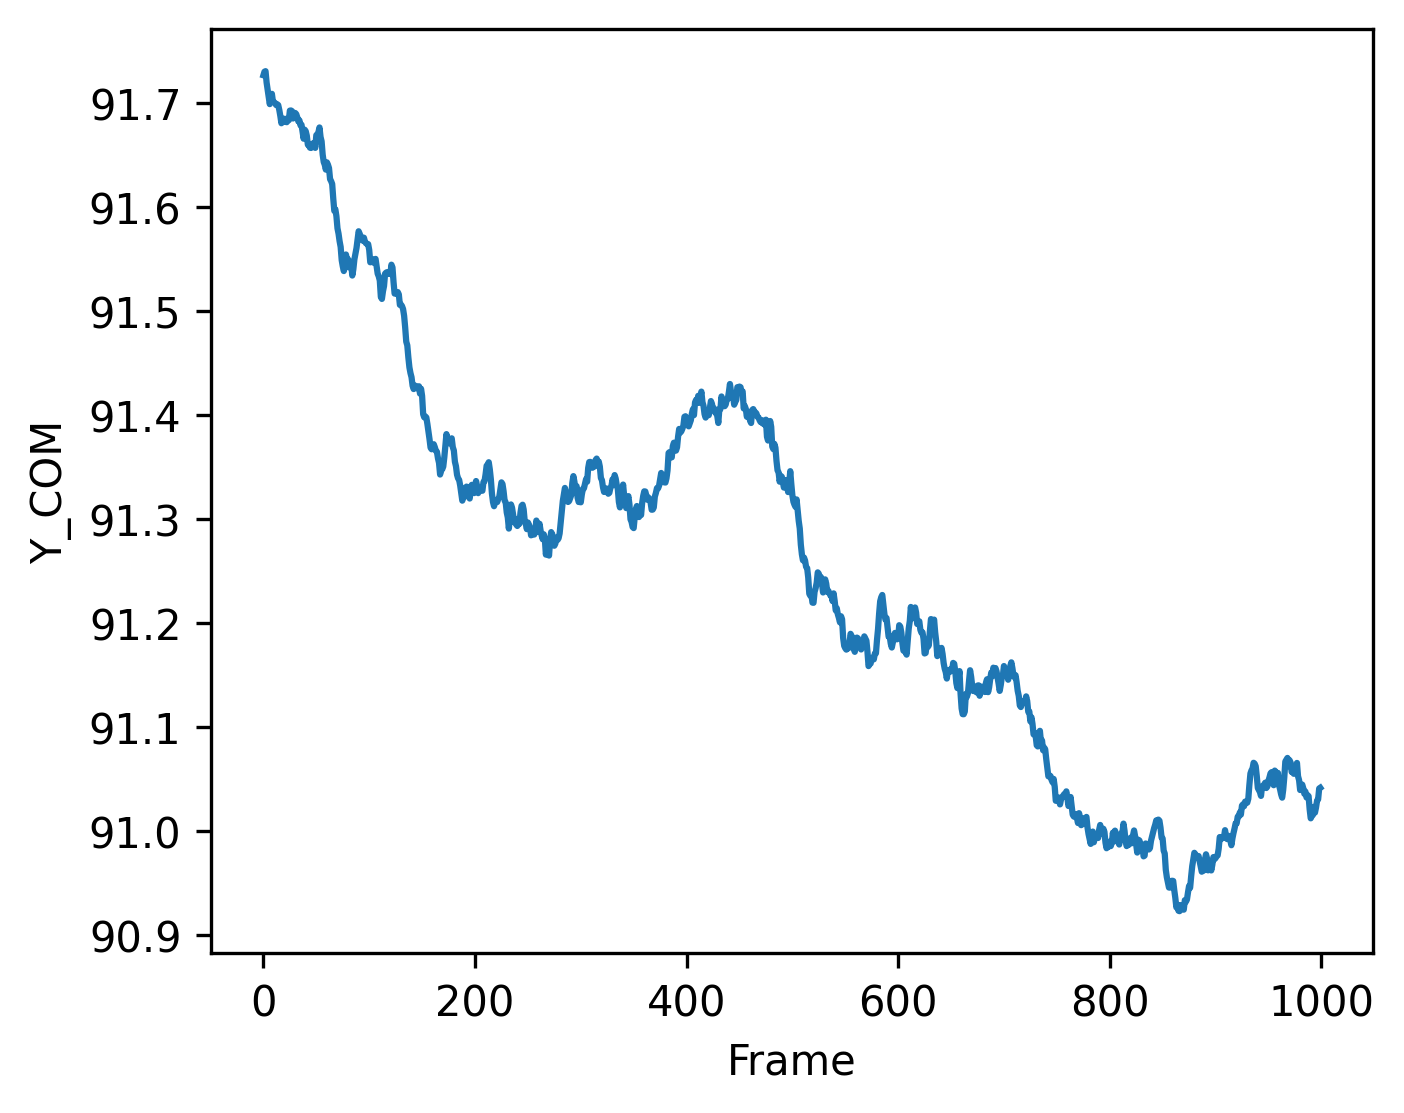

In [ ]:
plt.figure(figsize=(5,4),dpi=300)
plt.plot(Xcom)
plt.xlabel('Frame')
plt.ylabel('X_COM')
plt.savefig(fname+'Xcom.png')
plt.figure(figsize=(5,4),dpi=300)
plt.plot(Ycom)
plt.xlabel('Frame')
plt.ylabel('Y_COM')
plt.savefig(fname+'Ycom.png')
fulltime = np.arange(lastframe)

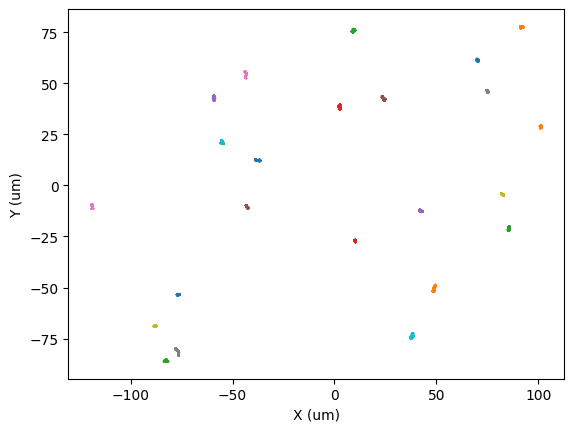

In [ ]:
msds = []
xpos = []
ypos = []
i = []
msdsizes = []
first_values = []
last_values = []
for l in range(int(len(pos))):
    start = int(pos[str(l)]['trackData'][0, 0])
    xpos = pos[str(l)]['trackData'][0:minframe, 1] * pixel_conversion - Xcom[start:start + minframe]
    ypos = pos[str(l)]['trackData'][0:minframe, 2] * pixel_conversion - Ycom[start:start + minframe]
    plt.plot(xpos, ypos)
    nData = len(xpos)
    numberOfdeltaT = int(nData / 2)
    msd = np.zeros((numberOfdeltaT, 2))
    k = 0
    for dt in range(numberOfdeltaT + 1):
        if dt == 0:
            continue
        deltax = xpos[1 + dt:len(xpos) - 1] - xpos[1:len(xpos) - 1 - dt]
        deltay = ypos[1 + dt:len(ypos) - 1] - ypos[1:len(ypos) - 1 - dt]
        sD = deltax ** 2 + deltay ** 2
        msd[k, 0] = frametime * dt
        msd[k, 1] = np.mean(sD)
        k = k + 1
    msds.append({"time": msd[:, 0], "MSD": msd[:, 1]})
    msdsizes.append(len(msd))
    first_values.append(msd[0, 1])
    last_values.append(msd[-1, 1])
    xpos = []
    ypos = []
    i = []
    plt.xlabel('X (um)')
    plt.ylabel('Y (um)')
    plt.savefig(fname + 'tracks.png')


In [ ]:
(xpos[1+dt:len(xpos)-1]), (xpos[1:len(xpos)-1-dt])

([], [])

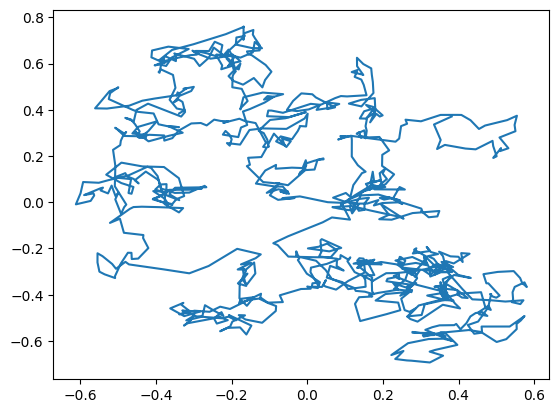

In [ ]:
start = int(pos[str(0)]['trackData'][0, 0])
xpos = pos[str(0)]['trackData'][0:minframe, 1] * pixel_conversion - Xcom[start:start + minframe]
ypos = pos[str(0)]['trackData'][0:minframe, 2] * pixel_conversion - Ycom[start:start + minframe]
xpos = xpos - np.mean(xpos)
ypos = ypos - np.mean(ypos)
plt.plot(xpos, ypos)
np.savetxt("individual track.txt", np.transpose(np.array([xpos, ypos])))
plt.savefig(fname + 'individual track.png')


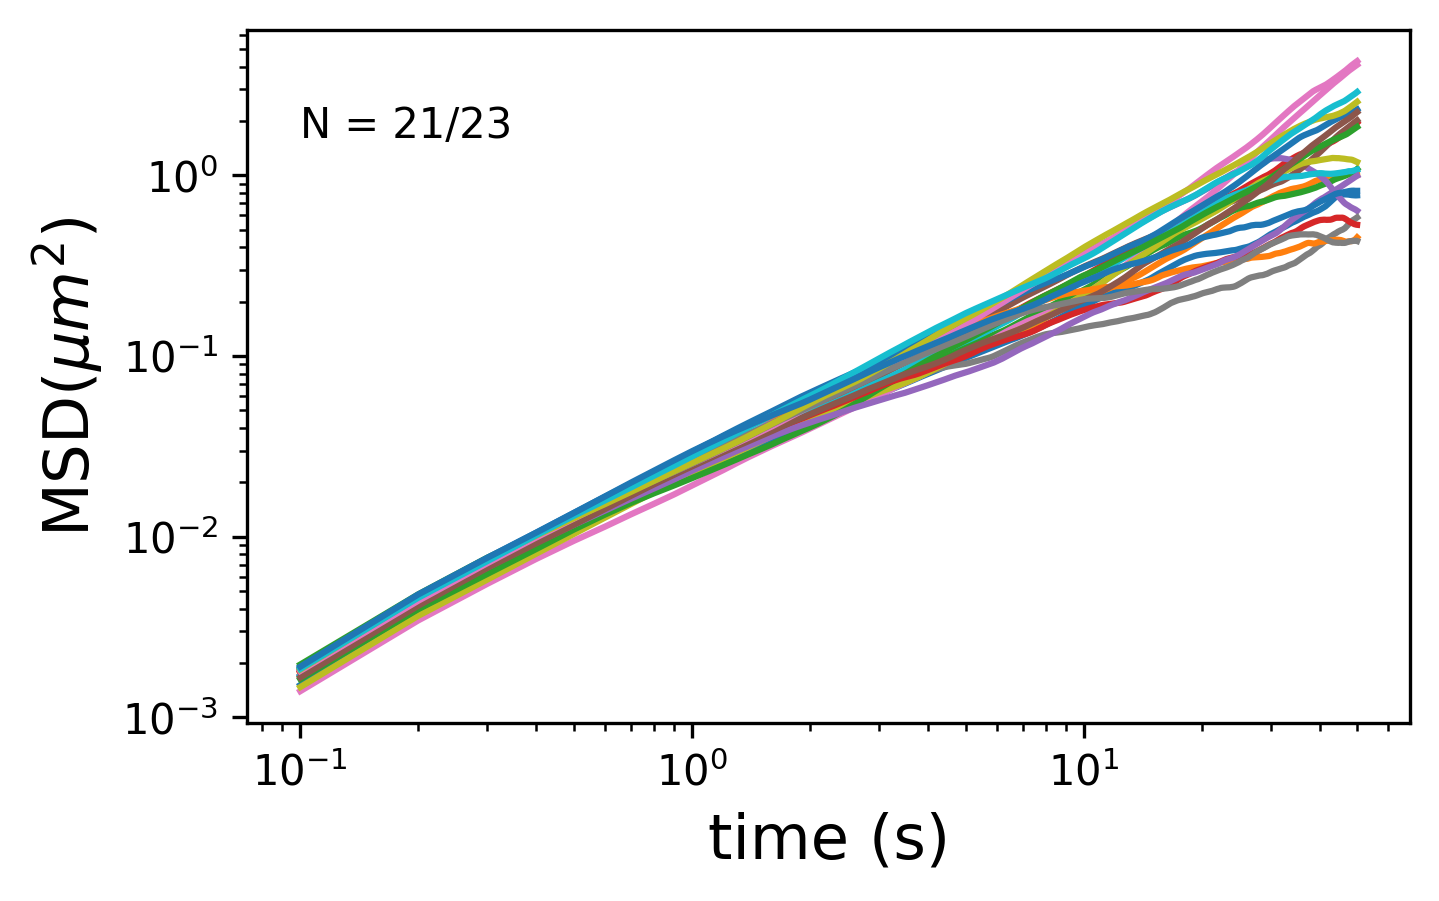

In [ ]:
lower_bound, upper_bound, lower_bound_l, upper_bound_l = get_outlier_bounds(first_values, last_values)
lastind = np.min(msdsizes) - 1
totmsd = np.zeros((lastind,))
msd_all = np.zeros((lastind, len(msds)))
plt.figure(figsize=(5, 3), dpi=300)
plt.xlabel('time (s)', fontsize=15)
plt.ylabel('MSD($\mu m^2$)', fontsize=15)
count = 0
for i in range(len(msds)):
    mmd = np.array(msds[i]['MSD'])
    time = msds[i]['time']
    if not lower_bound < np.log(mmd[0]) < upper_bound or not lower_bound_l < np.log(mmd[-1]) < upper_bound_l or mmd[lastind] < 1e-9:
        continue
    plt.loglog(time[:lastind], mmd[:lastind])
    totmsd = totmsd + mmd[0:lastind]
    count += 1
msdavg = totmsd / count
plt.text(min(time), max(msdavg), 'N = ' + str(count) + '/' + str(len(msds)))
plt.savefig(fname + 'MSDs_all.eps', bbox_inches='tight')
plt.savefig(fname + 'MSDs_all.png', bbox_inches='tight')
time = time[0:lastind]
np.savetxt(fname + 'MSD_new.txt', np.transpose([time, msdavg]), delimiter='\t')


In [ ]:
import numpy as np

# Define a function to calculate the Mean Squared Displacement (MSD) using NumPy
def calculate_msd_numpy(xpos, ypos, frametime, minframe):
    # Initialize an empty list to store MSD values (not used in this function, so could be removed)
    msds = []

    # Calculate the total number of data points
    nData = len(xpos)

    # Determine the number of delta T intervals for which MSD will be calculated, usually half the data length
    numberOfdeltaT = int(nData / 2)

    # Initialize a zero array to store the time intervals and corresponding MSD values
    msd = np.zeros((numberOfdeltaT, 2))

    # Loop over all delta T intervals to calculate MSD for each
    for dt in range(1, numberOfdeltaT + 1):
        # Calculate the difference in x and y positions for particles separated by time interval dt
        deltax = xpos[dt:nData] - xpos[:nData - dt]
        deltay = ypos[dt:nData] - ypos[:nData - dt]

        # Calculate the squared displacement for each pair of points
        sD = deltax**2 + deltay**2

        # Store the current time interval in the first column
        msd[dt-1, 0] = frametime * dt

        # Calculate and store the mean squared displacement for the current time interval in the second column
        msd[dt-1, 1] = np.mean(sD)

    # Return the time intervals and their corresponding MSD values
    return msd[:, 0], msd[:, 1]


In [ ]:
import tensorflow as tf

# Assuming xpos and ypos are lists or arrays containing the x and y positions over time
# Convert xpos and ypos to TensorFlow constants to be used in the TensorFlow graph
xpos_tf = tf.constant(xpos, dtype=tf.float32)
ypos_tf = tf.constant(ypos, dtype=tf.float32)

# Define a function to calculate MSD using TensorFlow operations
def calculate_msd_tensorflow(xpos, ypos, frametime, minframe):
    # Get the total number of data points
    nData = tf.size(xpos)
    # Calculate the number of time intervals for MSD calculation, half the number of data points
    numberOfdeltaT = tf.cast(nData / 2, tf.int32)
    # Create a TensorArray to store the MSD calculations for each time interval
    msd = tf.TensorArray(dtype=tf.float32, size=numberOfdeltaT, dynamic_size=False)

    # Define a sub-function to compute squared displacement for each time interval
    def compute_displacement(delta_t, msd):
        # Calculate the difference in positions for the given time interval
        deltax = xpos[1 + delta_t:nData - 1] - xpos[1:nData - 1 - delta_t]
        deltay = ypos[1 + delta_t:nData - 1] - ypos[1:nData - 1 - delta_t]
        # Square the differences to get squared displacement
        squared_displacement = tf.square(deltax) + tf.square(deltay)
        # Average the squared displacement to get the mean squared displacement
        mean_squared_displacement = tf.reduce_mean(squared_displacement)
        # Store the mean squared displacement in the TensorArray
        msd = msd.write(delta_t-1, (frametime * tf.cast(delta_t, tf.float32), mean_squared_displacement))
        # Move to the next time interval
        return delta_t + 1, msd

    # Execute the while_loop to fill the TensorArray with MSD values for each time interval
    _, msd_final = tf.while_loop(
        cond=lambda delta_t, _: delta_t <= numberOfdeltaT,
        body=compute_displacement,
        loop_vars=(tf.constant(1), msd)
    )

    # Extract the results from the TensorArray and stack them into a single tensor
    msd_result = msd_final.stack()
    # Return the final tensor of MSD values
    return msd_result

# Use the function to calculate MSD
msd_tf = calculate_msd_tensorflow(xpos_tf, ypos_tf, frametime, minframe)
# Convert the TensorFlow tensor back to a NumPy array for further analysis or usage
msd_tf = msd_tf.numpy()


In [ ]:
import time

# NumPy version comparison
start_time = time.time()
time_np, msd_np = calculate_msd_numpy(xpos, ypos, frametime, minframe)
numpy_duration = time.time() - start_time
print(f"NumPy version took {numpy_duration:.4f} seconds.")

# TensorFlow version comparison
# Ensure xpos_tf and ypos_tf are TensorFlow tensors
start_time = time.time()
msd_tf = calculate_msd_tensorflow(xpos_tf, ypos_tf, frametime, minframe)
msd_tf = msd_tf.numpy()  # Convert the result back to a NumPy array for comparison
tensorflow_duration = time.time() - start_time
print(f"TensorFlow version took {tensorflow_duration:.4f} seconds.")

# Comparing outputs
# Assuming the first column is time and the second is MSD in both outputs
differences = np.abs(msd_np - msd_tf[:, 1])  # Comparing MSD values directly
print(f"Maximum difference between NumPy and TensorFlow MSD outputs: {np.max(differences)}")


NumPy version took 0.0170 seconds.
TensorFlow version took 1.7860 seconds.
Maximum difference between NumPy and TensorFlow MSD outputs: 0.0015738485279863657


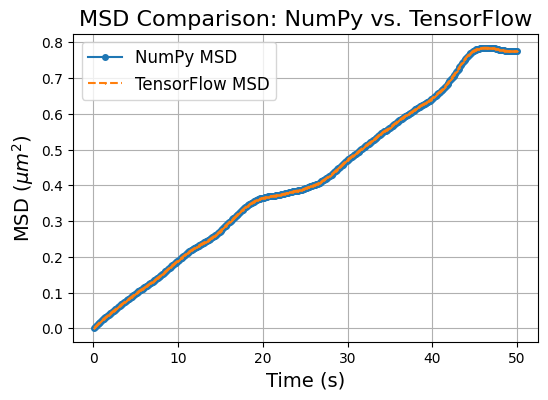

In [ ]:
import matplotlib.pyplot as plt

# Assuming time_np, msd_np, and msd_tf[:, 1] (MSD values from TensorFlow) are already defined

plt.figure(figsize=(6, 4))

# Plotting NumPy results
plt.plot(time_np, msd_np, label='NumPy MSD', marker='o', linestyle='-', markersize=4)

# Plotting TensorFlow results
# Note: Ensure the TensorFlow MSD values are extracted correctly if msd_tf[:, 1] doesn't directly apply
plt.plot(time_np, msd_tf[:, 1], label='TensorFlow MSD', marker='x', linestyle='--', markersize=1)

plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('MSD ($\mu m^2$)', fontsize=14)
plt.title('MSD Comparison: NumPy vs. TensorFlow', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
